<a href="https://colab.research.google.com/github/ortall0201/Spotify-Playlist-Recommender-System-Using-NLP/blob/main/Manor/Triplet_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# call preprocessed data

csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/cleaned_step4.csv'
playlists_df = pd.read_csv(csv_file_path)

In [3]:
playlists_df.head()

,user_id,artist_name,track_name,playlist_name,song_name,unq_playlist_name,track_word_count
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,(the angels wanna wear my) red shoes,hard rock 2010,elvis costello - (the angels wanna wear my) re...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,7
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"(what's so funny 'bout) peace, love and unders...",hard rock 2010,elvis costello & the attractions - (what's so ...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,8
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,hard rock 2010,tiffany page - 7 years too late,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,4
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,hard rock 2010,elvis costello & the attractions - accidents w...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,3
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,hard rock 2010,elvis costello - alison,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,1


In [4]:
playlists_df.shape

(8827807, 7)

In [5]:
# Number of unique artists

playlists_df['artist_name'].nunique()
print(f"Number of unique artists: {playlists_df['artist_name'].nunique()}")

# Number of unique users

unique_users = playlists_df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

# Number of unique songs

unique_songs = playlists_df['song_name'].nunique()
print(f"Number of unique songs: {unique_songs}")

Number of unique artists: 223712
Number of unique users: 15351
Number of unique songs: 1913703


In [6]:
import random
from tqdm import tqdm  # For progress tracking

import random
from tqdm import tqdm  # For progress tracking

def generate_triplets(df, max_positives=3, verbose=True):
    """
    Generate triplets with random negative sampling (no precomputed pools).

    Parameters:
    - df: DataFrame with 'playlist_id' and 'song_id'.
    - max_positives: Number of positives to sample per anchor.
    - verbose: Whether to print progress updates.

    Returns:
    - List of triplets (anchor, positive, negative).
    """
    playlists = df.groupby('unq_playlist_name')['song_name'].apply(list).to_dict()
    all_songs = list(df['song_name'].unique())  # Global pool of songs
    triplets = set()  # Use a set to track unique triplets

    # Progress bar if verbose is enabled
    if verbose:
        print("Starting triplet generation...")
        pbar = tqdm(total=len(playlists), desc="Processing playlists")

    for playlist_id, playlist_songs in playlists.items():
        for anchor in playlist_songs:
            if len(playlist_songs) > 1:
                # Sample up to max_positives for this anchor
                positives = random.sample([song for song in playlist_songs if song != anchor],
                                          min(max_positives, len(playlist_songs) - 1))
                for positive in positives:
                    # Randomly sample a negative from the global pool
                    negative = random.choice(all_songs)
                    # Ensure negative is not in the same playlist
                    while negative in playlist_songs:
                        negative = random.choice(all_songs)

                    # Add the triplet
                    triplets.add((anchor, positive, negative))

        # Update progress bar
        if verbose:
            pbar.update(1)

    if verbose:
        pbar.close()
        print(f"Triplet generation complete. Generated {len(triplets)} unique triplets.")

    return list(triplets)



triplets = generate_triplets(playlists_df)



Starting triplet generation...


Processing playlists: 100%|██████████| 214394/214394 [03:20<00:00, 1071.84it/s]


Triplet generation complete. Generated 26473185 unique triplets.


In [20]:
# save triplets as df to avoid crash troubles

triplets_df = pd.DataFrame(list(triplets), columns=['anchor', 'positive', 'negative'])
output_csv_path = '/content/drive/My Drive/Colab Notebooks/Final Project/triplets.csv'
triplets_df.to_csv(output_csv_path, index=False)



In [21]:
triplets_df.shape

(19328608, 3)

In [22]:
triplets_df.isna().sum()

,0
anchor,0
positive,0
negative,0


In [23]:
unique_counts = {col: triplets_df[col].nunique() for col in triplets_df.columns}
unique_counts

{'anchor': 1913703, 'positive': 1843301, 'negative': 1913621}

In [1]:
# call triplets back to set - mount drive (1)

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# call triplets back to set - call data (2)


csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/triplets.csv'
loaded_triplets = pd.read_csv(csv_file_path)
triplets = set(loaded_triplets.itertuples(index=False, name=None))

In [9]:
# Balance triplet anchors

# Count occurrences of each anchor
anchor_counts = Counter([triplet[0] for triplet in triplets])

# Group triplets by anchor
anchor_to_triplets = {}
for triplet in triplets:
    anchor = triplet[0]
    if anchor not in anchor_to_triplets:
        anchor_to_triplets[anchor] = []
    anchor_to_triplets[anchor].append(triplet)

# Downsample triplets for dominant anchors
balanced_triplets = []
for anchor, triplet_list in anchor_to_triplets.items():
    if len(triplet_list) > 100:
        # Randomly sample to limit the number of triplets
        balanced_triplets.extend(random.sample(triplet_list, 100))
    else:
        # Keep all triplets for non-dominant anchors
        balanced_triplets.extend(triplet_list)

triplets = balanced_triplets



In [5]:
from collections import Counter

# Count how often each song appears as an anchor
anchors = [triplet[0] for triplet in triplets]
anchor_counts = Counter(anchors)

# Compare with the original dataset
all_songs = set(playlists_df['song_name'])
missing_songs = all_songs - set(anchors)

print(f"Number of unique anchors: {len(set(anchors))}")
print(f"Songs missing as anchors: {len(missing_songs)}")
print(f"Most common anchors: {anchor_counts.most_common(5)}")


Number of unique anchors: 1913703
Songs missing as anchors: 0
Most common anchors: [('the antlers - putting the dog to sleep', 100), ('regina spektor - jessica', 100), ('rick ross - free mason', 100), ('ryuichi sakamoto - merry christmas mr. lawrence', 100), ("the smiths - i know it's over - 2011 remastered version", 100)]


In [12]:
# Count how often each positive pair appears
positive_pairs = [(triplet[0], triplet[1]) for triplet in triplets]
positive_pair_counts = Counter(positive_pairs)

print(f"Number of unique positive pairs: {len(set(positive_pairs))}")
print(f"Most common positive pairs: {positive_pair_counts.most_common(5)}")


Number of unique positive pairs: 18206256
Most common positive pairs: [(('lorde - still sane', 'lorde - tennis court'), 16), (('childish gambino - poke', 'childish gambino - v. 3005 - beach picnic version'), 15), (('brian eno - 1/2 - 2004 digital remaster', 'brian eno - 2/2 - 2004 digital remaster'), 15), (('godspeed you! black emperor - their helicopters sing', 'godspeed you! black emperor - mladic'), 14), (('brian eno - 1/2 - 2004 digital remaster', 'brian eno - 1/1 - 2004 digital remaster'), 14)]


In [13]:
# Count how often each song appears as a negative
negatives = [triplet[2] for triplet in triplets]
negative_counts = Counter(negatives)

print(f"Number of unique negatives: {len(set(negatives))}")
print(f"Most common negatives: {negative_counts.most_common(5)}")


Number of unique negatives: 1913621
Most common negatives: [("the ramones - we're a happy family", 29), ('daniel givens - transitional', 29), ('andrew bird - railroad bill', 28), ("shakin' stevens - rockin' little christmas - remastered version", 28), ('woods of desolation - this autumn light', 28)]


In [15]:
# Count how many playlists contribute to triplets
playlist_ids_in_triplets = set(playlists_df[playlists_df['song_name'].isin(anchors)]['unq_playlist_name'])

print(f"Number of playlists in dataset: {playlists_df['unq_playlist_name'].nunique()}")
print(f"Number of playlists in triplets: {len(playlist_ids_in_triplets)}")


Number of playlists in dataset: 214394
Number of playlists in triplets: 214394


In [7]:
print(f"Total triplets: {len(triplets)}")
print(f"Unique triplets: {len(set(triplets))}")
print(f"Proportion of unique triplets: {len(set(triplets)) / len(triplets):.2f}")


Total triplets: 19328608
Unique triplets: 19328608
Proportion of unique triplets: 1.00


In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def check_triplet_balance_ratios(df, triplets):
    """
    Check balance of triplets by analyzing song and playlist ratios.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).

    Returns:
    - None. Displays summary statistics and visualizations.
    """
    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()
    total_songs = len(dataset_song_counts)

    # Playlist coverage
    total_playlists = df['unq_playlist_name'].nunique()
    playlists_in_triplets = df[df['song_name'].isin(anchors)]['unq_playlist_name'].nunique()
    playlist_coverage_ratio = playlists_in_triplets / total_playlists

    # Unique vs. Total Triplets Ratio
    unique_triplets_ratio = len(set(triplets)) / len(triplets)

    # Display summary statistics
    print(f"Total songs in dataset: {total_songs}")
    print(f"Total playlists in dataset: {total_playlists}")
    print(f"Playlists contributing to triplets: {playlists_in_triplets} ({playlist_coverage_ratio:.2%})")
    print(f"Unique triplets: {len(set(triplets))} / Total triplets: {len(triplets)} ({unique_triplets_ratio:.2%})")


check_triplet_balance_ratios(playlists_df, triplets)


Total songs in dataset: 1913703
Total playlists in dataset: 214394
Playlists contributing to triplets: 214394 (100.00%)
Unique triplets: 19328608 / Total triplets: 19328608 (100.00%)


Summary Statistics:
       dataset_ratio  anchor_ratio  positive_ratio  negative_ratio
count   1.913703e+06  1.913703e+06    1.913703e+06    1.913703e+06
mean    5.225471e-07  5.225471e-07    5.225471e-07    5.225471e-07
std     2.454709e-06  9.064188e-07    1.658527e-06    1.645610e-07
min     1.132784e-07  1.034736e-07    0.000000e+00    0.000000e+00
25%     1.132784e-07  1.552103e-07    1.034736e-07    4.138943e-07
50%     1.132784e-07  1.552103e-07    2.069471e-07    5.173678e-07
75%     3.398353e-07  4.656310e-07    4.138943e-07    6.208414e-07
max     2.555561e-04  5.173678e-06    1.555725e-04    1.500367e-06

Top-K Most Common Anchors:
                                                                                            song_name  \
song_name                                                                                               
m83 - midnight city                                                               m83 - midnight city   
daft punk - get lucky - radio edit

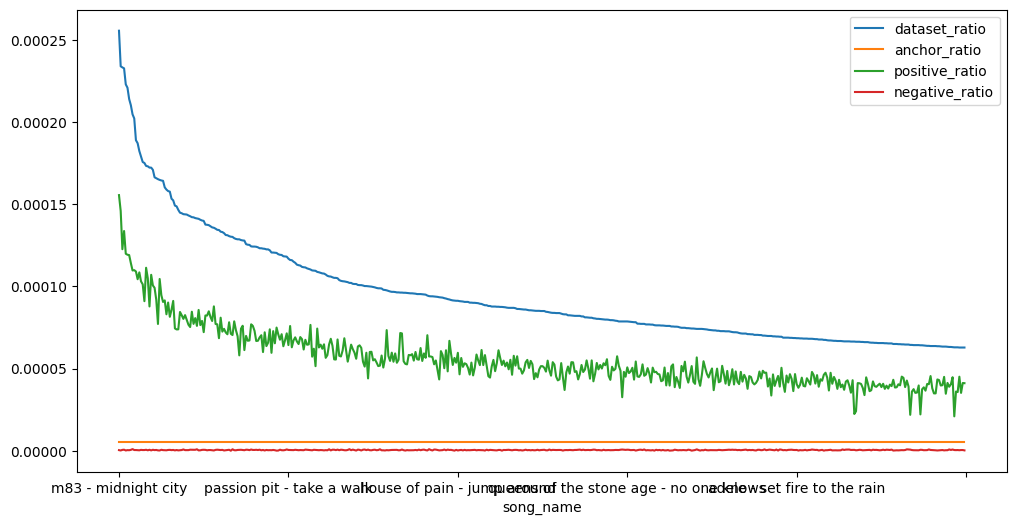

In [6]:
def check_triplet_balance_ratios_light(df, triplets, top_k=10):
    """
    Check balance of triplets with summary statistics and light visualizations.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).
    - top_k: Number of top and bottom songs to display in statistics.

    Returns:
    - None. Prints summary statistics and displays key insights.
    """
    from collections import Counter
    import pandas as pd

    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()

    # Calculate ratios
    song_ratios = pd.DataFrame({
        'song_name': dataset_song_counts.index,
        'dataset_ratio': dataset_song_counts / dataset_song_counts.sum(),
        'anchor_ratio': [anchor_counts[song] / len(anchors) if song in anchor_counts else 0 for song in dataset_song_counts.index],
        'positive_ratio': [positive_counts[song] / len(positives) if song in positive_counts else 0 for song in dataset_song_counts.index],
        'negative_ratio': [negative_counts[song] / len(negatives) if song in negative_counts else 0 for song in dataset_song_counts.index],
    })

    # Summary statistics
    print("Summary Statistics:")
    print(song_ratios.describe())

    # Top-K and Bottom-K Songs
    print("\nTop-K Most Common Anchors:")
    print(song_ratios.nlargest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    print("\nTop-K Most Common Positives:")
    print(song_ratios.nlargest(top_k, 'positive_ratio')[['song_name', 'positive_ratio']])

    print("\nTop-K Most Common Negatives:")
    print(song_ratios.nlargest(top_k, 'negative_ratio')[['song_name', 'negative_ratio']])

    print("\nBottom-K Least Common Anchors:")
    print(song_ratios.nsmallest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    # Optionally, plot subsampled ratios
    subset_ratios = song_ratios.head(500)  # Limit to top 500 for plotting
    subset_ratios.plot(x='song_name', y=['dataset_ratio', 'anchor_ratio', 'positive_ratio', 'negative_ratio'], kind='line', figsize=(12, 6))

check_triplet_balance_ratios_light(playlists_df, triplets)

